In [1]:
! pip install bertopic

In [2]:
import json
import os
import csv
import torch

from torch.utils.data import Dataset
from tqdm import tqdm
from PIL import Image

from sklearn.feature_extraction.text import CountVectorizer

class FacebookHatefulMemeDataset(Dataset):

    def __init__(self, base_folder, split):
        self.data_set = []

        dataset_path = os.path.join(base_folder, split + '.jsonl')
        with open(dataset_path, 'r') as json_file:
            json_list = list(json_file)

        for json_str in json_list:
            result = json.loads(json_str)
            self.data_set.append(result)

    def __len__(self):
        return len(self.data_set)

    def __getitem__(self, index):
        return self.data_set[index]


class MAMIDataset(Dataset):
    def __init__(self, base_folder, split):
        self.data_set = []

        dataset_path = os.path.join(base_folder, split + '.tsv')

        # Open and parse the TSV file, directly populating self.data_set
        with open(dataset_path, 'r') as tsv_file:
            reader = csv.DictReader(tsv_file, delimiter='\t')

            for row in reader:
                data_entry = {
                    "img": "images/" + row['file_name'],
                    "label": int(row['label']),
                    "text": row['text']
                }
                self.data_set.append(data_entry)

    def __len__(self):
        return len(self.data_set)

    def __getitem__(self, index):
        return self.data_set[index]


class Harm_C_Dataset(Dataset):
    def __init__(self, base_folder, split):
        self.data_set = []

        dataset_path = os.path.join(base_folder, split + '.jsonl')
        with open(dataset_path, 'r') as json_file:
            json_list = list(json_file)

        for json_str in json_list:
            result = json.loads(json_str)
            result['label'] = 0 if 'not harmful' in result['labels'] else 1
            result['img'] = 'images/' + result['image']
            self.data_set.append(result)

    def __len__(self):
        return len(self.data_set)

    def __getitem__(self, index):
        return self.data_set[index]


class Harm_P_Dataset(Dataset):
    def __init__(self, base_folder, split):
        self.data_set = []

        dataset_path = os.path.join(base_folder, split + '.jsonl')
        with open(dataset_path, 'r') as json_file:
            json_list = list(json_file)

        for json_str in json_list:
            result = json.loads(json_str)
            result['label'] = 0 if 'not harmful' in result['labels'] else 1
            result['img'] = 'images/' + result['image']
            self.data_set.append(result)

    def __len__(self):
        return len(self.data_set)

    def __getitem__(self, index):
        return self.data_set[index]

In [3]:
class DatasetWrapper:
    def __init__(self, dataset_tag, base_folder, split):
        self.base_folder = base_folder
        print(dataset_tag, base_folder, split)
        if dataset_tag == "facebook_hateful_meme_dataset":
            self.dataset = FacebookHatefulMemeDataset(
                base_folder=base_folder,
                split=split
            )
        elif dataset_tag == "MAMI_dataset":
            self.dataset = MAMIDataset(
                base_folder=base_folder,
                split=split
            )
        elif dataset_tag == "Harm_P_Dataset":
            self.dataset = Harm_P_Dataset(
                base_folder=base_folder,
                split=split
            )
        elif dataset_tag == "Harm_C_Dataset":
            self.dataset = Harm_C_Dataset(
                base_folder=base_folder,
                split=split
            )

    def get_dataset(self):
        return self.dataset

    def get_base_folder(self):
        return self.base_folder

In [4]:
dataset_wrapper_c = DatasetWrapper(
    dataset_tag="Harm_C_Dataset",
    base_folder="/kaggle/input/harm-c-memes-dataset",
    split="test"
)

dataset_wrapper_p = DatasetWrapper(
    dataset_tag="Harm_P_Dataset",
    base_folder="/kaggle/input/harm-p-memes-dataset",
    split="test"
)

Harm_C_Dataset /kaggle/input/harm-c-memes-dataset test
Harm_P_Dataset /kaggle/input/harm-p-memes-dataset test


In [5]:
import json

with open("/kaggle/input/slic-data-cases/indices.json", 'r') as json_file:
    data_represent = json.load(json_file)

case_a = []
case_b = []

misclassified = []

case_a_file = "/LLaVA 13B/HARM-C/CASE 3"
case_b_file = "/LLaVA 13B/HARM-C/CASE 4"

for itemize in data_represent[case_a_file]:
    case_a.append(itemize)
    misclassified.append(itemize)

for itemize in data_represent[case_b_file]:
    case_b.append(itemize)
    misclassified.append(itemize)

assert len(misclassified) == len(case_a) + len(case_b)
print(len(misclassified), len(case_a), len(case_b))

case_a_file = "/LLaVA 13B/HARM-P/CASE 3"
case_b_file = "/LLaVA 13B/HARM-P/CASE 4"

for itemize in data_represent[case_a_file]:
    case_a.append(itemize)
    misclassified.append(itemize)

for itemize in data_represent[case_b_file]:
    case_b.append(itemize)
    misclassified.append(itemize)

assert len(misclassified) == len(case_a) + len(case_b)
print(len(misclassified), len(case_a), len(case_b))

44 31 13
97 56 41


In [6]:
images = []
docs = []

for image in dataset_wrapper_c.get_dataset():
    # print(image["img"])
    if image["img"].split("/")[-1] in misclassified:
        images.append(os.path.join(dataset_wrapper_c.get_base_folder(), image["img"]))
        docs.append(image["text"])

for image in dataset_wrapper_p.get_dataset():
    # print(image["img"])
    if image["img"].split("/")[-1] in misclassified:
        images.append(os.path.join(dataset_wrapper_p.get_base_folder(), image["img"]))
        docs.append(image["text"])

assert len(images) == len(docs) and len(images) == len(misclassified)
print(len(images), len(docs))

97 97


In [7]:
from bertopic import BERTopic

from bertopic.representation import KeyBERTInspired, VisualRepresentation
from bertopic.backend import MultiModalBackend
from sklearn.cluster import KMeans

from umap import UMAP

cluster_model = KMeans(n_clusters=2)

umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

# Image embedding model
embedding_model = MultiModalBackend('clip-ViT-B-32', batch_size=32)

# Image to text representation model
representation_model = {
    "Visual_Aspect": VisualRepresentation(image_to_text_model="nlpconnect/vit-gpt2-image-captioning")
}

# Vectorizer
vectorizer_model = CountVectorizer(stop_words="english")

# Train our model with images only
topic_model = BERTopic(
    umap_model=umap_model,
    embedding_model=embedding_model,
    representation_model=representation_model,
    vectorizer_model=vectorizer_model,
    hdbscan_model=cluster_model
)
topics, probs = topic_model.fit_transform(documents=docs, images=images)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Token indices sequence length is longer than the specified maximum sequence length for this model (92 > 77). Running this sequence through the model will result in indexing errors
100%|██████████| 2/2 [00:00<00:00, 20.94it/s]


,Topic,Count,Name,Representation,Visual_Aspect,Representative_Docs
0,0,80,0_trump_lp_covid_19,"[trump, lp, covid, 19, biden, obama, joe, party, donald, democratic]",,"[BREAKING NEWS\nPRESIDENT DONALD\nTRUMP TESTS POSITIVE\nFOR COVID-19\n, WHO WOULD WIN?\nDONALD TRUMP\nCOVID-19\n, LP\nLP\nLP\nLP\nLP\nLP\nLP\nLP\nLP\nLP\nLP\nLP\ntrump roasting\nbiden for\nLP\nLP\nLP\nLP\ncovid\n19\nwearing mask\nLP\nLP\nLP\nLP\n]"
1,1,17,1_libertarian_party_ip_org,"[libertarian, party, ip, org, post, locally, involved, thanks, states, lie]",,"[""So, if we lie to the government,\nit's a felony.\nBut if they lie\nto us\nits politics.""\nBI Murray\nThanks to the Alaska\nLibertarian Party for this post!\nTo get involved locally, go to\nIp.org/states!\n, GOOD IDEAS DON'T REQUIRE FORCE\nTLIBERTARIAN\nThanks to the Libertarian Party\nof Florida for this post! To get\ninvolved locally, go to\nIp.org/states!\n, GOOD IDEAS DON'T REQUIRE FORCE\nTLIBERTARIAN\nThanks to the Libertarian Party\nof Florida for this post! To get\ninvolved locally, go to\nIp.org/states!\n]"

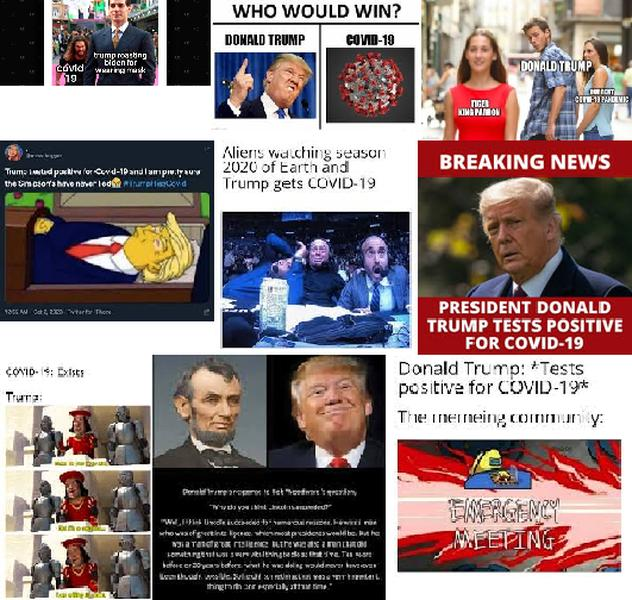
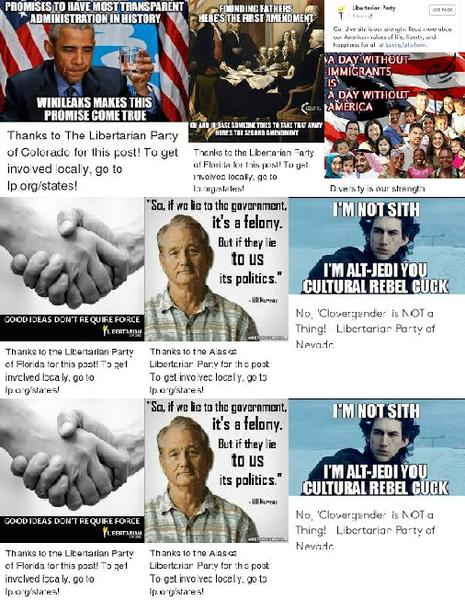

In [8]:
import base64
from io import BytesIO
from IPython.display import HTML

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()


def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

# Extract dataframe
df = topic_model.get_topic_info()

# Visualize the images
HTML(df.to_html(formatters={'Visual_Aspect': image_formatter}, escape=False))


In [9]:
grouped_topics = {topic: [] for topic in set(topics)}
for index, topic in enumerate(topics):
    grouped_topics[topic].append(index)
print(grouped_topics)

{0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 53, 54, 55, 57, 58, 61, 62, 64, 65, 66, 68, 69, 71, 72, 73, 74, 75, 76, 77, 78, 79, 81, 84, 85, 86, 87, 88, 91, 92, 93, 95], 1: [46, 50, 51, 52, 56, 59, 60, 63, 67, 70, 80, 82, 83, 89, 90, 94, 96]}


In [10]:
print(case_a_file, case_b_file, sep="\n")

a = 0
b = 0

assert len(grouped_topics) == 2
assert 0 in grouped_topics and 1 in grouped_topics

for item in grouped_topics[0]:
    if misclassified[item] in case_a:
        a += 1
    else:
        assert misclassified[item] in case_b
        b += 1

print(int(round(a/(a+b), 2)*100), int(round(b/(a+b), 2)*100))

a = 0
b = 0

for item in grouped_topics[1]:
    if misclassified[item] in case_a:
        a += 1
    else:
        assert misclassified[item] in case_b
        b += 1

print(int(round(a/(a+b), 2)*100), int(round(b/(a+b), 2)*100))

/LLaVA 13B/HARM-P/CASE 3
/LLaVA 13B/HARM-P/CASE 4
59 41
53 47
